<a href="https://colab.research.google.com/github/Rosvend/Passenger-flow-prediction-LSTM/blob/main/LSTM_Metro_passenger_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM (Long short-term memory) neural network para la predicción a corto plazo del flujo de pasajeros en la red metro de Medellín, Antioquia.**

Este proyecto busca predecir el flujo de pasajeros en la red Metro de Medellín, Antioquia. Para esto se utilizan herramientas como PyTorch para construir una red neuronal LSTM, buscando patrones clave para la detección de características de comportamientos que permitan mejorar el rendimiento y operacionalidad de las redes metro, además de brindar ideas relevantes para la resolución de problemas.

In [ ]:
!pip install cudf-cu11 index-url=https://pypi.nvidia.com

In [ ]:
%load_ext cudf.pandas

# Importando librerías

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from ipywidgets import interact, interact_manual, Dropdown
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import datetime

In [ ]:
!pip install holidays_co

In [ ]:
from holidays_co import get_colombia_holidays_by_year
holidays = get_colombia_holidays_by_year(2024)
print(holidays)

[Holiday(date=datetime.date(2023, 1, 1), celebration='Año Nuevo'), Holiday(date=datetime.date(2023, 1, 9), celebration='Día de los Reyes Magos'), Holiday(date=datetime.date(2023, 3, 20), celebration='Día de San José'), Holiday(date=datetime.date(2023, 4, 6), celebration='Jueves Santo'), Holiday(date=datetime.date(2023, 4, 7), celebration='Viernes Santo'), Holiday(date=datetime.date(2023, 5, 1), celebration='Día del Trabajo'), Holiday(date=datetime.date(2023, 5, 22), celebration='Ascensión del Señor'), Holiday(date=datetime.date(2023, 6, 12), celebration='Corphus Christi'), Holiday(date=datetime.date(2023, 6, 19), celebration='Sagrado Corazón de Jesús'), Holiday(date=datetime.date(2023, 7, 3), celebration='San Pedro y San Pablo'), Holiday(date=datetime.date(2023, 7, 20), celebration='Día de la Independencia'), Holiday(date=datetime.date(2023, 8, 7), celebration='Batalla de Boyacá'), Holiday(date=datetime.date(2023, 8, 21), celebration='La Asunción de la Virgen'), Holiday(date=datetime.d

In [ ]:
from holidays_co import is_holiday_date

date = datetime.date(2024,5,13) #Lunes festivo 13 de mayo 2024 como ejemplo (Dia de la Ascencion)

print(date)
is_holiday_date(date)

2024-05-13


True

#Cargando datos


In [ ]:
print('Descargando archivos...')
!curl -L "https://drive.google.com/uc?id=1Vk3kISIRnWhpF55VAlsXiaBC7-2VS7mp&export=download" -o Afluencia2024.xlsx
!curl -L "https://drive.google.com/uc?id=1rawKGyqGLCjhYsE1oePv499lQdawN3zX&export=download" -o Afluencia2023.xlsx
!curl -L "https://drive.google.com/uc?id=11VeQzlInoljZKKil7kPcWjwvESCZbMSv&export=download" -o Afluencia2022.xlsx
!curl -L "https://drive.google.com/uc?id=1zWP6FHA6aTJJ58xy119k5tAQRxI3DEIF&export=download" -o Afluencia2021.xlsx
!curl -L "https://drive.google.com/uc?id=1klQ3qzRFX2-jpkc4Nh8wLIo6weFKQ6Pa&export=download" -o Afluencia2020.xlsx
!curl -L "https://drive.google.com/uc?id=1PsQvhT1bt6-xr5vG1Xi95aHBg2anYI51&export=download" -o Afluencia2019.xlsx

Descargando archivos...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60500  100 60500    0     0  83334      0 --:--:-- --:--:-- --:--:--  141k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  659k  100  659k    0     0   465k      0  0:00:01  0:00:01 --:--:-- 5235k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  648k  100  648k    0     0   369k      0  0:00:01  0:00:01 --:--:-- 1407k
  % Total    % Received % Xf

In [ ]:
df2019 = pd.read_excel('/content/Afluencia2019.xlsx',engine='openpyxl')
df2020 = pd.read_excel('/content/Afluencia2020.xlsx',engine='openpyxl')
df2021 = pd.read_excel('/content/Afluencia2021.xlsx',engine='openpyxl')
df2022 = pd.read_excel('/content/Afluencia2022.xlsx',engine='openpyxl')
df2023 = pd.read_excel('/content/Afluencia2023.xlsx',engine='openpyxl')
df2024 = pd.read_excel('/content/Afluencia2024.xlsx',engine='openpyxl')
df2023.head(13) #Imprimos las 12 lineas del metro

,Día,Línea de Servicio,Hora de operación,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
1,01/01/2023,LÍNEA 1,192,811,896,716,673,922,1023,1208,...,1629,1985,2361,2694,2303,1839,1478,236,NaN,25483
2,01/01/2023,LÍNEA 2,11,123,116,95,102,144,147,189,...,191,255,280,317,252,164,111,7,NaN,3210
3,01/01/2023,LÍNEA A,1328,5104,5701,4309,4054,4852,5880,7629,...,10999,13027,15965,19123,15663,12918,9509,819,NaN,166047
4,01/01/2024,LÍNEA B,221,701,750,655,628,863,1085,1228,...,1930,2247,2498,2648,2029,1472,1087,151,NaN,25106
5,01/01/2023,LÍNEA H,NaN,NaN,NaN,NaN,NaN,56,62,49,...,55,128,99,109,68,46,27,1,NaN,970
6,01/01/2023,LÍNEA J,NaN,NaN,NaN,NaN,NaN,470,410,490,...,688,710,857,933,651,311,146,3,NaN,7209
7,01/01/2023,LÍNEA K,NaN,NaN,NaN,NaN,350,555,630,745,...,1432,1515,1788,1562,1110,766,329,4,NaN,13664
8,01/01/2023,LÍNEA L,NaN,NaN,NaN,NaN,11,61,158,364,...,617,531,428,NaN,NaN,NaN,NaN,NaN,NaN,4113
9,01/01/2023,LÍNEA M,NaN,NaN,NaN,NaN,1,156,123,176,...,229,332,319,411,408,260,240,92,NaN,3425


# Proceso de calidad de datos

In [ ]:
df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   3564 non-null   object
 1   Unnamed: 1   3564 non-null   object
 2   Unnamed: 2   2937 non-null   object
 3   Unnamed: 3   2958 non-null   object
 4   Unnamed: 4   2960 non-null   object
 5   Unnamed: 5   2989 non-null   object
 6   Unnamed: 6   3426 non-null   object
 7   Unnamed: 7   3501 non-null   object
 8   Unnamed: 8   3499 non-null   object
 9   Unnamed: 9   3517 non-null   object
 10  Unnamed: 10  3513 non-null   object
 11  Unnamed: 11  3515 non-null   object
 12  Unnamed: 12  3524 non-null   object
 13  Unnamed: 13  3517 non-null   object
 14  Unnamed: 14  3525 non-null   object
 15  Unnamed: 15  3536 non-null   object
 16  Unnamed: 16  3361 non-null   object
 17  Unnamed: 17  3226 non-null   object
 18  Unnamed: 18  3230 non-null   object
 19  Unnamed: 19  3228 non-null 

In [ ]:
df2019.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,Día,Línea de servicio,Hora de operación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
2,2019-01-01 00:00:00,Línea 1,12,826,1134,987,884,975,1259,1348,...,2085,2230,2636,2884,2603,2024,1257,271,5,28850
3,2019-01-02 00:00:00,Línea 1,1716,4498,6629,6284,4145,3784,3746,3854,...,4709,5750,7517,6661,4307,2975,2709,1890,135,83484
4,2019-01-03 00:00:00,Línea 1,1860,4869,7587,7088,4483,4486,4126,4136,...,5061,6093,8023,7034,4481,3244,2905,1739,124,90472


In [ ]:
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2019 = df2019.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2019.columns.to_list()

['Unnamed: 0',
 'Unnamed: 1',
 '4AM',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [ ]:
df2019 = df2019.rename(columns={'Unnamed: 0':'Dia','Unnamed: 1':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2019 = df2019.drop([0,1])
df2019.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
2,2019-01-01 00:00:00,Línea 1,12,826,1134,987,884,975,1259,1348,...,2085,2230,2636,2884,2603,2024,1257,271,5,28850
3,2019-01-02 00:00:00,Línea 1,1716,4498,6629,6284,4145,3784,3746,3854,...,4709,5750,7517,6661,4307,2975,2709,1890,135,83484
4,2019-01-03 00:00:00,Línea 1,1860,4869,7587,7088,4483,4486,4126,4136,...,5061,6093,8023,7034,4481,3244,2905,1739,124,90472
5,2019-01-04 00:00:00,Línea 1,1845,4989,7723,7281,4857,4583,4269,4217,...,5280,6056,7992,7081,4805,3466,3075,1900,176,93067
6,2019-01-05 00:00:00,Línea 1,1550,3852,4898,5221,4016,3815,3704,4048,...,4696,4528,4106,4377,3842,2973,2866,1983,167,75451


In [ ]:
df2020.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,Día,Línea de servicio,Hora de operación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
2,2020-01-01 00:00:00,Línea 1,NaN,902,1126,881,743,924,1137,1299,...,2056,2374,2727,2908,2978,2457,1369,174,NaN,29341
3,2020-01-01 00:00:00,Línea 2,NaN,63,94,66,68,61,79,127,...,169,188,287,302,236,188,85,16,NaN,2435
4,2020-01-01 00:00:00,Línea A,1,4901,6168,4822,4158,5152,6467,8488,...,12785,15911,19522,20582,20358,16450,10701,1177,NaN,192714


In [ ]:
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2020 = df2020.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2020.columns.to_list()

['Unnamed: 0',
 'Unnamed: 1',
 '4AM',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [ ]:
df2020 = df2020.rename(columns={'Unnamed: 0':'Dia','Unnamed: 1':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2020 = df2020.drop([0,1])
df2020.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
2,2020-01-01 00:00:00,Línea 1,NaN,902,1126,881,743,924,1137,1299,...,2056,2374,2727,2908,2978,2457,1369,174,NaN,29341
3,2020-01-01 00:00:00,Línea 2,NaN,63,94,66,68,61,79,127,...,169,188,287,302,236,188,85,16,NaN,2435
4,2020-01-01 00:00:00,Línea A,1,4901,6168,4822,4158,5152,6467,8488,...,12785,15911,19522,20582,20358,16450,10701,1177,NaN,192714
5,2020-01-01 00:00:00,Línea B,NaN,750,863,674,693,891,1161,1600,...,2140,2775,2942,3083,2319,1738,725,39,NaN,28691
6,2020-01-01 00:00:00,Línea H,NaN,NaN,NaN,NaN,1,39,60,65,...,66,130,105,136,121,49,14,2,NaN,1030


In [ ]:
df2021.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,Día,Línea de servicio,Hora de operación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
2,2021-01-01 00:00:00,LÍNEA A,NaN,3487,3405,2011,1148,974,888,1011,...,1833,2900,3269,3314,2273,1329,12,NaN,NaN,31911
3,2021-01-01 00:00:00,LÍNEA B,NaN,532,438,267,164,145,135,142,...,212,321,421,432,215,157,NaN,NaN,NaN,4050
4,2021-01-01 00:00:00,LÍNEA K,NaN,NaN,NaN,NaN,40,131,104,156,...,167,258,189,122,103,38,NaN,NaN,NaN,1714


In [ ]:
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2021 = df2021.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2021.columns.to_list()

['Unnamed: 0',
 'Unnamed: 1',
 '4AM',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [ ]:
df2021 = df2021.rename(columns={'Unnamed: 0':'Dia','Unnamed: 1':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2021 = df2021.drop([0,1])
df2021.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
2,2021-01-01 00:00:00,LÍNEA A,NaN,3487,3405,2011,1148,974,888,1011,...,1833,2900,3269,3314,2273,1329,12,NaN,NaN,31911
3,2021-01-01 00:00:00,LÍNEA B,NaN,532,438,267,164,145,135,142,...,212,321,421,432,215,157,NaN,NaN,NaN,4050
4,2021-01-01 00:00:00,LÍNEA K,NaN,NaN,NaN,NaN,40,131,104,156,...,167,258,189,122,103,38,NaN,NaN,NaN,1714
5,2021-01-01 00:00:00,LÍNEA J,NaN,NaN,NaN,NaN,1,77,74,92,...,146,179,132,135,69,42,3,NaN,NaN,1256
6,2021-01-01 00:00:00,LÍNEA 1,NaN,614,590,355,240,217,198,231,...,394,579,624,574,399,231,17,NaN,NaN,6104


In [ ]:
df2021['Dia'] = pd.to_datetime(df2021['Dia'], format='%d/%m/%Y', errors='coerce')
df2021.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
2,2021-01-01,LÍNEA A,NaN,3487,3405,2011,1148,974,888,1011,...,1833,2900,3269,3314,2273,1329,12,NaN,NaN,31911
3,2021-01-01,LÍNEA B,NaN,532,438,267,164,145,135,142,...,212,321,421,432,215,157,NaN,NaN,NaN,4050
4,2021-01-01,LÍNEA K,NaN,NaN,NaN,NaN,40,131,104,156,...,167,258,189,122,103,38,NaN,NaN,NaN,1714
5,2021-01-01,LÍNEA J,NaN,NaN,NaN,NaN,1,77,74,92,...,146,179,132,135,69,42,3,NaN,NaN,1256
6,2021-01-01,LÍNEA 1,NaN,614,590,355,240,217,198,231,...,394,579,624,574,399,231,17,NaN,NaN,6104


In [ ]:
df2022.head()

,Día,Línea de Servicio,Hora de operación,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaT,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
1,2022-01-01,LÍNEA 1,165,811,854,662,589,731,836,1091,...,1479,1616,1696,1911,1611,1319,923,132,NaN,20279
2,2022-01-01,LÍNEA 2,14,90,100,81,68,95,93,90,...,168,212,213,222,169,118,71,8,NaN,2265
3,2022-01-01,LÍNEA A,1098,4363,5114,3988,3385,4033,4890,6163,...,9089,10642,11322,12716,10610,8085,6333,476,NaN,126692
4,2022-01-01,LÍNEA B,195,674,767,555,565,667,921,1246,...,1599,2121,2114,2204,1526,1028,620,58,NaN,21301


In [ ]:
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2022 = df2022.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2022.columns.to_list()

['Día',
 'Línea de Servicio',
 'Hora de operación',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [ ]:
df2022 = df2022.rename(columns={'Día':'Dia','Línea de Servicio':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2022 = df2022.drop([0])
df2022.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
1,2022-01-01,LÍNEA 1,165,811,854,662,589,731,836,1091,...,1479,1616,1696,1911,1611,1319,923,132,NaN,20279
2,2022-01-01,LÍNEA 2,14,90,100,81,68,95,93,90,...,168,212,213,222,169,118,71,8,NaN,2265
3,2022-01-01,LÍNEA A,1098,4363,5114,3988,3385,4033,4890,6163,...,9089,10642,11322,12716,10610,8085,6333,476,NaN,126692
4,2022-01-01,LÍNEA B,195,674,767,555,565,667,921,1246,...,1599,2121,2114,2204,1526,1028,620,58,NaN,21301
5,2022-01-01,LÍNEA H,NaN,NaN,NaN,NaN,NaN,39,25,45,...,44,37,71,80,61,42,14,NaN,NaN,641


In [ ]:
df2023.head()

,Día,Línea de Servicio,Hora de operación,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
1,01/01/2023,LÍNEA 1,192,811,896,716,673,922,1023,1208,...,1629,1985,2361,2694,2303,1839,1478,236,NaN,25483
2,01/01/2023,LÍNEA 2,11,123,116,95,102,144,147,189,...,191,255,280,317,252,164,111,7,NaN,3210
3,01/01/2023,LÍNEA A,1328,5104,5701,4309,4054,4852,5880,7629,...,10999,13027,15965,19123,15663,12918,9509,819,NaN,166047
4,01/01/2024,LÍNEA B,221,701,750,655,628,863,1085,1228,...,1930,2247,2498,2648,2029,1472,1087,151,NaN,25106


In [ ]:
#Cambiamos los nombres de las columnas de horas
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2023 = df2023.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2023.columns.to_list()

['Día',
 'Línea de Servicio',
 'Hora de operación',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [ ]:
df2023 = df2023.rename(columns={'Día':'Dia','Línea de Servicio':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2023 = df2023.drop([0]) #Borramos la primera fila
df2023.head(12)

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
1,01/01/2023,LÍNEA 1,192,811,896,716,673,922,1023,1208,...,1629,1985,2361,2694,2303,1839,1478,236,NaN,25483
2,01/01/2023,LÍNEA 2,11,123,116,95,102,144,147,189,...,191,255,280,317,252,164,111,7,NaN,3210
3,01/01/2023,LÍNEA A,1328,5104,5701,4309,4054,4852,5880,7629,...,10999,13027,15965,19123,15663,12918,9509,819,NaN,166047
4,01/01/2024,LÍNEA B,221,701,750,655,628,863,1085,1228,...,1930,2247,2498,2648,2029,1472,1087,151,NaN,25106
5,01/01/2023,LÍNEA H,NaN,NaN,NaN,NaN,NaN,56,62,49,...,55,128,99,109,68,46,27,1,NaN,970
6,01/01/2023,LÍNEA J,NaN,NaN,NaN,NaN,NaN,470,410,490,...,688,710,857,933,651,311,146,3,NaN,7209
7,01/01/2023,LÍNEA K,NaN,NaN,NaN,NaN,350,555,630,745,...,1432,1515,1788,1562,1110,766,329,4,NaN,13664
8,01/01/2023,LÍNEA L,NaN,NaN,NaN,NaN,11,61,158,364,...,617,531,428,NaN,NaN,NaN,NaN,NaN,NaN,4113
9,01/01/2023,LÍNEA M,NaN,NaN,NaN,NaN,1,156,123,176,...,229,332,319,411,408,260,240,92,NaN,3425
10,01/01/2023,LÍNEA O,10,122,172,99,107,138,95,150,...,216,234,272,326,222,198,109,14,NaN,2944


In [ ]:
df2024.head()

,Día,Línea de Servicio,Hora de Operación,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaT,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
1,2024-01-01,LÍNEA 1,203,894,964,773,709,901,1014,1133,...,1629,1793,2173,2439,1983,1737,1165,165,3,23946
2,2024-01-01,LÍNEA 2,5,158,152,83,109,143,132,249,...,202,292,312,301,221,161,107,16,NaN,3242
3,2024-01-01,LÍNEA A,1553,5705,5948,4926,4161,4673,5692,7401,...,10887,13231,15615,17187,14787,11986,7907,749,NaN,161634
4,2024-01-01,LÍNEA B,258,742,870,710,674,848,1092,1451,...,2014,2291,2653,2792,2081,1347,927,94,NaN,26116


In [ ]:
#Cambiamos los nombres de las columnas de horas
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2024 = df2024.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2024.columns.to_list()

['Día',
 'Línea de Servicio',
 'Hora de Operación',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [ ]:
df2024 = df2024.rename(columns={'Día':'Dia','Línea de Servicio':'Linea','Hora de Operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2024 = df2024.drop([0])
df2024.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
1,2024-01-01,LÍNEA 1,203,894,964,773,709,901,1014,1133,...,1629,1793,2173,2439,1983,1737,1165,165,3,23946
2,2024-01-01,LÍNEA 2,5,158,152,83,109,143,132,249,...,202,292,312,301,221,161,107,16,NaN,3242
3,2024-01-01,LÍNEA A,1553,5705,5948,4926,4161,4673,5692,7401,...,10887,13231,15615,17187,14787,11986,7907,749,NaN,161634
4,2024-01-01,LÍNEA B,258,742,870,710,674,848,1092,1451,...,2014,2291,2653,2792,2081,1347,927,94,NaN,26116
5,2024-01-01,LÍNEA H,NaN,NaN,NaN,NaN,2,59,67,84,...,78,101,85,121,83,43,29,7,NaN,990


In [ ]:
dfs = [df2019, df2020, df2021, df2022, df2023, df2024]
for df in dfs:
    if 'Dia' in df.columns:
        df['Dia'] = pd.to_datetime(df['Dia'], format='%d/%m/%Y', errors='coerce')

df = pd.concat(dfs, axis=0,ignore_index=True)
#df.to_excel('Afluencia2020-2024.xlsx',index=False)
df['Linea'] = df['Linea'].str.upper()
df.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
0,2019-01-01,LÍNEA 1,12,826,1134,987,884,975,1259,1348,...,2085,2230,2636,2884,2603,2024,1257,271,5,28850
1,2019-01-02,LÍNEA 1,1716,4498,6629,6284,4145,3784,3746,3854,...,4709,5750,7517,6661,4307,2975,2709,1890,135,83484
2,2019-01-03,LÍNEA 1,1860,4869,7587,7088,4483,4486,4126,4136,...,5061,6093,8023,7034,4481,3244,2905,1739,124,90472
3,2019-01-04,LÍNEA 1,1845,4989,7723,7281,4857,4583,4269,4217,...,5280,6056,7992,7081,4805,3466,3075,1900,176,93067
4,2019-01-05,LÍNEA 1,1550,3852,4898,5221,4016,3815,3704,4048,...,4696,4528,4106,4377,3842,2973,2866,1983,167,75451


In [ ]:
df['Festivo'] = df['Dia'].apply(is_holiday_date) #Anadimos una columna para dias festivos
df.head()

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros,Festivo
0,2019-01-01,LÍNEA 1,12,826,1134,987,884,975,1259,1348,...,2230,2636,2884,2603,2024,1257,271,5,28850,True
1,2019-01-02,LÍNEA 1,1716,4498,6629,6284,4145,3784,3746,3854,...,5750,7517,6661,4307,2975,2709,1890,135,83484,False
2,2019-01-03,LÍNEA 1,1860,4869,7587,7088,4483,4486,4126,4136,...,6093,8023,7034,4481,3244,2905,1739,124,90472,False
3,2019-01-04,LÍNEA 1,1845,4989,7723,7281,4857,4583,4269,4217,...,6056,7992,7081,4805,3466,3075,1900,176,93067,False
4,2019-01-05,LÍNEA 1,1550,3852,4898,5221,4016,3815,3704,4048,...,4528,4106,4377,3842,2973,2866,1983,167,75451,False


# Análisis exploratorio de los datos

In [ ]:
#Celda interactiva con hora, linea de metro y cantidad minima de pasajeros
@interact
def show_lines(Hora=['4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM'],
               Linea=df['Linea'].unique(),
               MinimoPasajeros=(10, 50000, 10)):
    return df.loc[(df[Hora] > MinimoPasajeros) & (df['Linea'] == Linea)]

interactive(children=(Dropdown(description='Hora', options=('4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', …

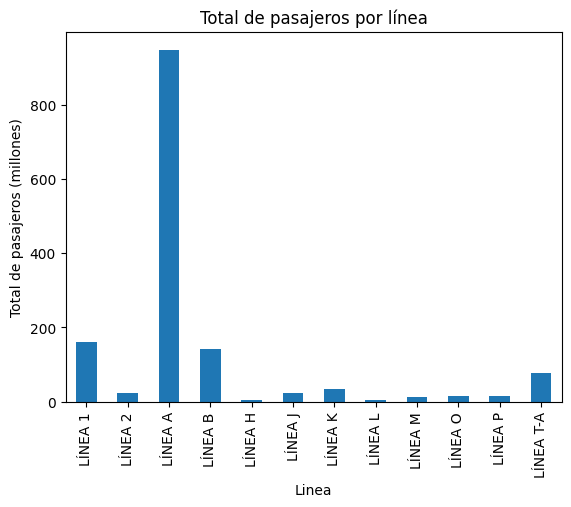

In [ ]:
ax = (df.groupby('Linea')['Total_pasajeros'].sum() / 1e6).plot(kind='bar')
plt.ylabel('Total de pasajeros (millones)')
plt.title('Total de pasajeros por línea')

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

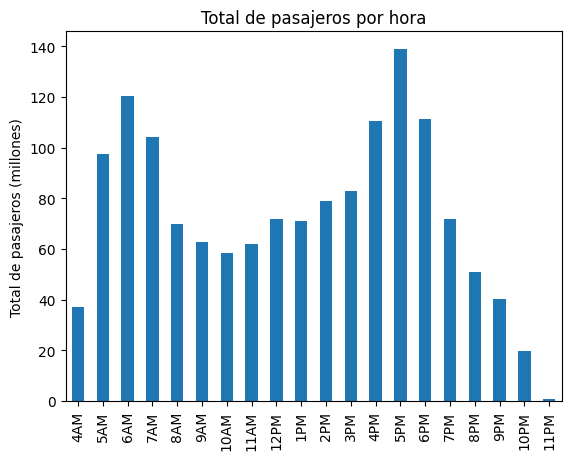

In [ ]:
ax = (df.drop(columns=['Dia','Linea','Total_pasajeros','Festivo']).sum()/ 1e6).plot(kind='bar')
plt.ylabel('Total de pasajeros (millones)')
plt.title('Total de pasajeros por hora')

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

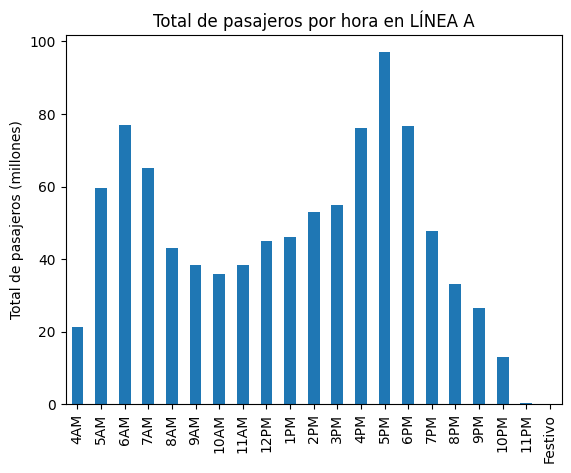

In [ ]:
df_linea_a = df[df['Linea'] == 'LÍNEA A']

passengers_by_hour = (df_linea_a.drop(columns=['Dia', 'Linea', 'Total_pasajeros']).sum() / 1e6)

ax = passengers_by_hour.plot(kind='bar')
plt.ylabel('Total de pasajeros (millones)')
plt.title('Total de pasajeros por hora en LÍNEA A')

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

In [ ]:
#grafica interactiva
def update_plot(line):
    df_filtered = df[df['Linea'] == line]
    passengers_by_hour = (df_filtered.drop(columns=['Dia', 'Linea', 'Total_pasajeros','Dia','Festivo','Dia_semana','Tipo de dia','Mes','Year']).sum() / 1e6)
    ax = passengers_by_hour.plot(kind='bar', figsize=(10, 5))
    plt.ylabel('Total de pasajeros (millones)')
    plt.title(f'Total de pasajeros por hora en {line}')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.show()

interact(update_plot, line=Dropdown(options=df['Linea'].unique(), value='LÍNEA A', description='Linea:'))


interactive(children=(Dropdown(description='Linea:', index=2, options=('LÍNEA 1', 'LÍNEA 2', 'LÍNEA A', 'LÍNEA…

<function __main__.update_plot(line)>

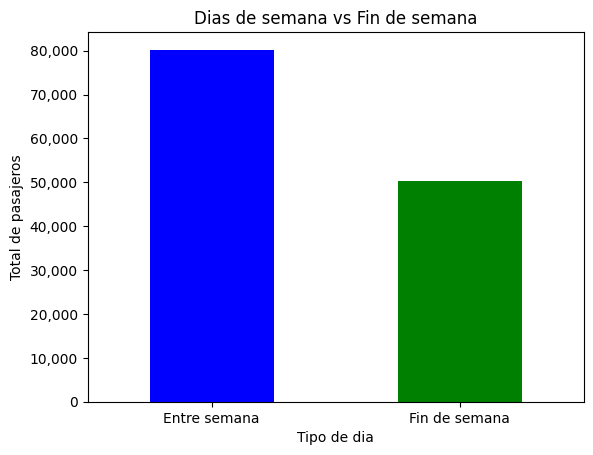

In [ ]:
df['Dia'] = pd.to_datetime(df['Dia'], format='%d/%m/%Y')

#Nueva columna para el dia de la semana (0=Lunes, 6=Domingo)
df['Dia_semana'] = df['Dia'].dt.dayofweek

# Clasificar como dia de semana o fin de semana
df['Tipo de dia'] = df['Dia_semana'].apply(lambda x: 'Fin de semana' if x >= 5 else 'Entre semana')

passenger_summary = df.groupby('Tipo de dia')['Total_pasajeros'].mean()


ax = passenger_summary.plot(kind='bar', color=['blue', 'green'])
plt.ylabel('Total de pasajeros')
plt.title('Dias de semana vs Fin de semana')
plt.xticks(rotation=0)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()
#visualizar en cada linea tambien

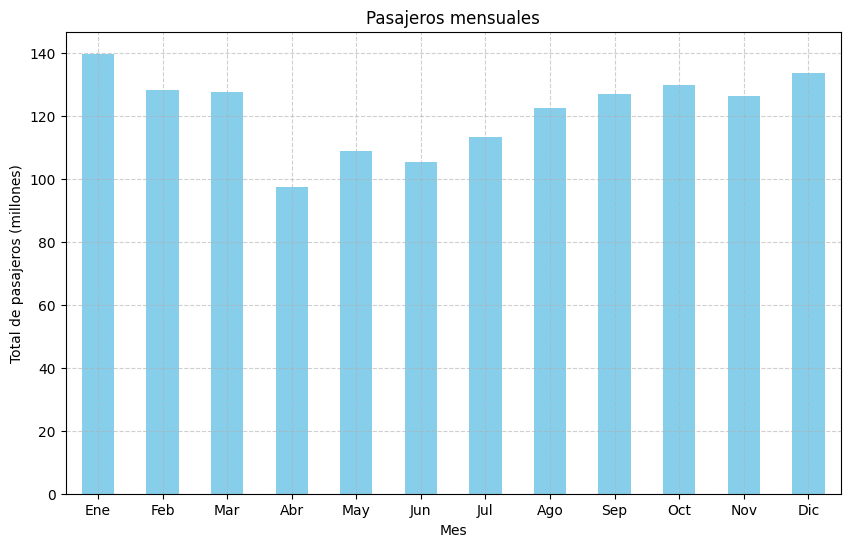

In [ ]:
df['Dia'] = pd.to_datetime(df['Dia'])

# Extraemos los meses de la columna dia
df['Mes'] = df['Dia'].dt.month

#Flujo de pasajeros por mes
monthly_passenger_flow = df.groupby('Mes')['Total_pasajeros'].sum()/1e6

plt.figure(figsize=(10, 6))
monthly_passenger_flow.plot(kind='bar', color='skyblue')
plt.title('Pasajeros mensuales')
plt.xlabel('Mes')
plt.ylabel('Total de pasajeros (millones)')
plt.xticks(ticks=range(len(monthly_passenger_flow)), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Datos nulos y cambiar tipo de datos

In [ ]:
df.replace('None', np.nan, inplace=True)

In [ ]:
print(df.isna().sum())

Dia                   0
Linea                 0
4AM                3145
5AM                3000
6AM                2989
7AM                2945
8AM                 809
9AM                 114
10AM                122
11AM                112
12PM                113
1PM                 116
2PM                 119
3PM                 144
4PM                 129
5PM                 123
6PM                1133
7PM                1520
8PM                1512
9PM                1518
10PM               1814
11PM               8941
Total_pasajeros       0
Festivo               0
Dia_semana            0
Tipo de dia           0
Mes                   0
dtype: int64


In [ ]:
print(df.isnull().sum())

Dia                   0
Linea                 0
4AM                3145
5AM                3000
6AM                2989
7AM                2945
8AM                 809
9AM                 114
10AM                122
11AM                112
12PM                113
1PM                 116
2PM                 119
3PM                 144
4PM                 129
5PM                 123
6PM                1133
7PM                1520
8PM                1512
9PM                1518
10PM               1814
11PM               8941
Total_pasajeros       0
Festivo               0
Dia_semana            0
Tipo de dia           0
Mes                   0
dtype: int64


In [ ]:
for col in df.columns[2:22]:
    df[col] = df[col].fillna(df[col].mean())
    df[col] = df[col].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20395 entries, 0 to 20394
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Dia              20395 non-null  datetime64[ns]
 1   Linea            20395 non-null  object        
 2   4AM              20395 non-null  int64         
 3   5AM              20395 non-null  int64         
 4   6AM              20395 non-null  int64         
 5   7AM              20395 non-null  int64         
 6   8AM              20395 non-null  int64         
 7   9AM              20395 non-null  int64         
 8   10AM             20395 non-null  int64         
 9   11AM             20395 non-null  int64         
 10  12PM             20395 non-null  int64         
 11  1PM              20395 non-null  int64         
 12  2PM              20395 non-null  int64         
 13  3PM              20395 non-null  int64         
 14  4PM              20395 non-null  int64

In [ ]:
df.isnull().sum()

Dia                0
Linea              0
4AM                0
5AM                0
6AM                0
7AM                0
8AM                0
9AM                0
10AM               0
11AM               0
12PM               0
1PM                0
2PM                0
3PM                0
4PM                0
5PM                0
6PM                0
7PM                0
8PM                0
9PM                0
10PM               0
11PM               0
Total_pasajeros    0
Festivo            0
Dia_semana         0
Tipo de dia        0
Mes                0
dtype: int64

In [ ]:
df['Total_pasajeros'] = pd.to_numeric(df['Total_pasajeros'], errors='coerce')
df['Year'] = df['Dia'].dt.year
df['Year'] = df['Year'].astype('category')
df['Tipo de dia'] = df['Tipo de dia'].astype('category')
df['Dia_semana'] = df['Dia_semana'].astype('category')
df['Mes'] = df['Mes'].astype('category')
df['Linea'] = df['Linea'].astype('category')
print(df.dtypes)

Dia                datetime64[ns]
Linea                    category
4AM                         int64
5AM                         int64
6AM                         int64
7AM                         int64
8AM                         int64
9AM                         int64
10AM                        int64
11AM                        int64
12PM                        int64
1PM                         int64
2PM                         int64
3PM                         int64
4PM                         int64
5PM                         int64
6PM                         int64
7PM                         int64
8PM                         int64
9PM                         int64
10PM                        int64
11PM                        int64
Total_pasajeros             int64
Festivo                      bool
Dia_semana               category
Tipo de dia              category
Mes                      category
Year                     category
dtype: object


# Visualizacion de los datos


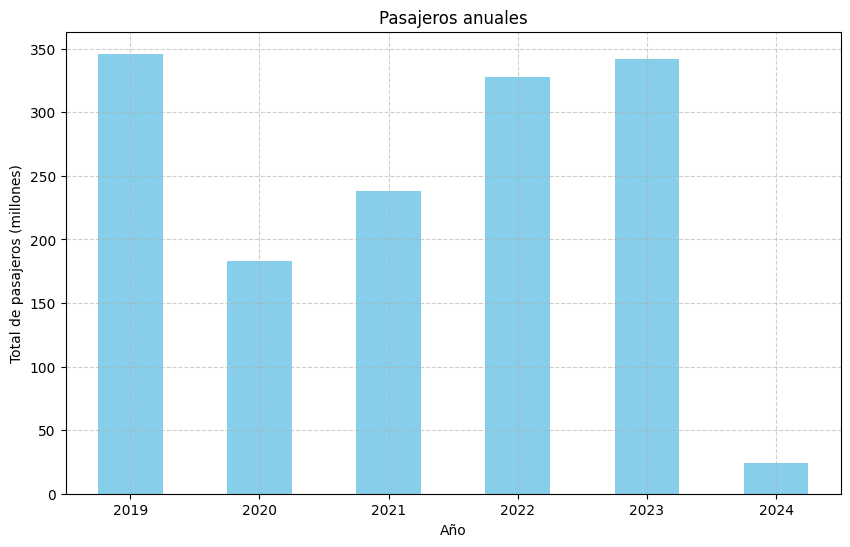

In [ ]:
pasajeros_anuales = df.groupby('Year')['Total_pasajeros'].sum()/1e6

plt.figure(figsize=(10, 6))
pasajeros_anuales.plot(kind='bar', color='skyblue')
plt.title('Pasajeros anuales')
plt.xlabel('Año')
plt.ylabel('Total de pasajeros (millones)')
plt.xticks(ticks=range(len(pasajeros_anuales)), labels=['2019', '2020', '2021', '2022', '2023', '2024'], rotation=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:

def update_plot(year):
    df_filtered = df[df['Year'] == year]

    monthly_passenger_flow = df_filtered.groupby('Mes')['Total_pasajeros'].sum() / 1e6

    ax = monthly_passenger_flow.plot(kind='bar', figsize=(10, 5), title=f'Total de pasajeros por mes en {year}')
    plt.ylabel('Total de pasajeros (millones)')
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.xticks(ticks=range(len(monthly_passenger_flow)), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
    plt.show()

year_options = df['Year'].unique()
default_year = year_options[0] if len(year_options) > 0 else None

interact(update_plot, year=Dropdown(options=year_options, value=default_year, description='Year:'))


interactive(children=(Dropdown(description='Year:', options=(2019, 2020, 2021, 2022, 2023, 2024), value=2019),…

<function __main__.update_plot(year)>

In [ ]:
import plotly.express as px

fig = px.scatter(df, x='Dia', y='Total_pasajeros', hover_data=['Dia_semana'])
fig.show()

FALTA VISUALIZARLO EN CADA LÍNEA DEL METRO

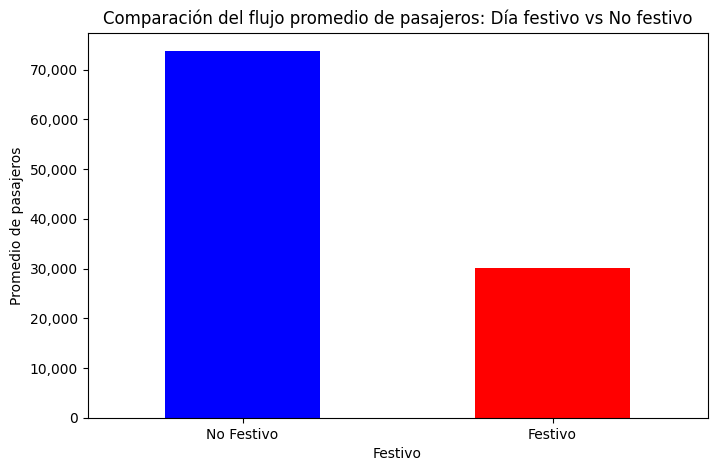

In [ ]:
passenger_summary = df.groupby('Festivo')['Total_pasajeros'].mean()

ax = passenger_summary.plot(kind='bar', color=['blue', 'red'], figsize=(8, 5))
plt.ylabel('Promedio de pasajeros')
plt.title('Comparación del flujo promedio de pasajeros: Día festivo vs No festivo')
plt.xticks([0, 1], ['No Festivo', 'Festivo'], rotation=0)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show() #visualizarlo en cada linea tambien

# Detección de outliers y duplicados

In [ ]:
def find_outliers_IQR(df, start_col, end_col):
    columns = df.loc[:, start_col:end_col].columns
    outliers_dict = {}

    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        IQR = q3 - q1
        outliers = df[(df[col] < (q1 - 1.5 * IQR)) | (df[col] > (q3 + 1.5 * IQR))]
        outliers_dict[col] = outliers

    return outliers_dict

outliers_dict = find_outliers_IQR(df, '4AM', '11PM')

# Imprimir cantidad de outliers por cada hora
for hour, data in outliers_dict.items():
    print(f'Hora: {hour}, Cantidad de outliers: {len(data)}')

Hora: 4AM, Cantidad de outliers: 1484
Hora: 5AM, Cantidad de outliers: 1479
Hora: 6AM, Cantidad de outliers: 1463
Hora: 7AM, Cantidad de outliers: 1450
Hora: 8AM, Cantidad de outliers: 1693
Hora: 9AM, Cantidad de outliers: 1989
Hora: 10AM, Cantidad de outliers: 1761
Hora: 11AM, Cantidad de outliers: 1770
Hora: 12PM, Cantidad de outliers: 1836
Hora: 1PM, Cantidad de outliers: 1981
Hora: 2PM, Cantidad de outliers: 1875
Hora: 3PM, Cantidad de outliers: 1798
Hora: 4PM, Cantidad de outliers: 1919
Hora: 5PM, Cantidad de outliers: 2269
Hora: 6PM, Cantidad de outliers: 1720
Hora: 7PM, Cantidad de outliers: 1731
Hora: 8PM, Cantidad de outliers: 1719
Hora: 9PM, Cantidad de outliers: 1737
Hora: 10PM, Cantidad de outliers: 1461
Hora: 11PM, Cantidad de outliers: 345


In [ ]:
def find_column_outliers_IQR(df, columns):
    outliers = pd.DataFrame(index=df.index)

    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        IQR = q3 - q1
        outliers[col] = (df[col] < (q1 - 1.5 * IQR)) | (df[col] > (q3 + 1.5 * IQR))

    return outliers

hour_columns = df.loc[:, '4AM':'11PM'].columns
column_outliers = find_column_outliers_IQR(df, hour_columns)

# Print number of outliers per column
for col in hour_columns:
    print(f'Column: {col}, Number of outliers: {column_outliers[col].sum()}')

Column: 4AM, Number of outliers: 1484
Column: 5AM, Number of outliers: 1479
Column: 6AM, Number of outliers: 1463
Column: 7AM, Number of outliers: 1450
Column: 8AM, Number of outliers: 1693
Column: 9AM, Number of outliers: 1989
Column: 10AM, Number of outliers: 1761
Column: 11AM, Number of outliers: 1770
Column: 12PM, Number of outliers: 1836
Column: 1PM, Number of outliers: 1981
Column: 2PM, Number of outliers: 1875
Column: 3PM, Number of outliers: 1798
Column: 4PM, Number of outliers: 1919
Column: 5PM, Number of outliers: 2269
Column: 6PM, Number of outliers: 1720
Column: 7PM, Number of outliers: 1731
Column: 8PM, Number of outliers: 1719
Column: 9PM, Number of outliers: 1737
Column: 10PM, Number of outliers: 1461
Column: 11PM, Number of outliers: 345


In [ ]:
row_outliers = pd.DataFrame(index=df.index)
for col in hour_columns:
    row_outliers[col] = df.index.isin(outliers_dict[col].index)

combined_outliers = pd.DataFrame(index=df.index)
for col in hour_columns:
    combined_outliers[col] = row_outliers[col] & column_outliers[col]

# Count the number of combined outliers for each hour column
combined_outliers_summary = combined_outliers.sum()
print(combined_outliers_summary)


4AM     1484
5AM     1479
6AM     1463
7AM     1450
8AM     1693
9AM     1989
10AM    1761
11AM    1770
12PM    1836
1PM     1981
2PM     1875
3PM     1798
4PM     1919
5PM     2269
6PM     1720
7PM     1731
8PM     1719
9PM     1737
10PM    1461
11PM     345
dtype: int64


In [ ]:
# Identify rows with any common outliers
common_outliers = combined_outliers.any(axis=1)

# Extract and display rows that are common outliers
common_outliers_df = df[common_outliers]
common_outliers_df.sample(10)

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,8PM,9PM,10PM,11PM,Total_pasajeros,Festivo,Dia_semana,Tipo de dia,Mes,Year
896,2019-06-16,LÍNEA A,2628,8954,11485,11254,12451,14445,17300,18268,...,18916,13877,1239,73,301819,False,6,Fin de semana,6,2019
801,2019-03-13,LÍNEA A,3600,5214,3311,1351,26,26027,2882,261549,...,28782,20139,10370,88,727640,False,2,Entre semana,3,2019
1414,2019-11-16,LÍNEA B,2320,5404,6500,6730,5277,4913,4830,5545,...,3118,2675,1736,15,97260,False,5,Fin de semana,11,2019
15767,2023-01-03,LÍNEA A,11581,28036,38350,32714,20935,18418,17692,19335,...,18788,14592,8355,2,499334,False,1,Entre semana,1,2023
1058,2019-11-25,LÍNEA A,15547,47388,68805,57742,36603,32883,29840,30451,...,25203,21438,11696,147,780595,False,0,Entre semana,11,2019
14379,2022-09-07,LÍNEA A,16403,48289,64559,54013,32208,28566,24918,26113,...,22021,17794,9588,70,712492,False,2,Entre semana,9,2022
4732,2020-04-20,LÍNEA A,5212,12177,12429,7931,4305,3428,3569,3524,...,2981,2458,216,73,115286,False,0,Entre semana,4,2020
9763,2021-08-11,LÍNEA A,13204,36464,46331,37169,23458,19656,18316,18176,...,15456,11616,6192,39,516137,False,2,Entre semana,8,2021
274,2019-10-02,LÍNEA 1,2845,9383,11801,11304,6946,5969,5013,5512,...,4469,3689,2016,120,128468,False,2,Entre semana,10,2019
329,2019-11-26,LÍNEA 1,2767,8682,11348,10878,7179,6081,5416,5432,...,4023,3484,2001,113,123740,False,1,Entre semana,11,2019


In [ ]:
#Numero total de festivos y dias no festivos
total_holidays = df['Festivo'].sum()
total_non_holidays = len(df) - total_holidays

# numero total de dias fin de semana y dias de semana
total_weekends = df[df['Tipo de dia'] == 'Fin de semana'].shape[0]
total_weekdays = len(df) - total_weekends

# Relacion de outliers con fin de semana y festivos con datos normalizados
for hour, outliers in outliers_dict.items():
    total_outliers = len(outliers)
    holiday_outliers = outliers['Festivo'].sum()
    weekend_outliers = outliers[outliers['Tipo de dia'] == 'Fin de semana'].shape[0]

    holiday_proportion = holiday_outliers / total_holidays if total_holidays != 0 else 0
    non_holiday_proportion = (total_outliers - holiday_outliers) / total_non_holidays if total_non_holidays != 0 else 0

    weekend_proportion = weekend_outliers / total_weekends if total_weekends != 0 else 0
    weekday_proportion = (total_outliers - weekend_outliers) / total_weekdays if total_weekdays != 0 else 0

    print(f'Hora: {hour}')
    print(f'  Total outliers: {total_outliers}')
    print(f'  Outliers on holidays: {holiday_outliers} ({holiday_proportion * 100:.2f}%)')
    print(f'  Outliers on non-holidays: {total_outliers - holiday_outliers} ({non_holiday_proportion * 100:.2f}%)')
    print(f'  Outliers on weekends: {weekend_outliers} ({weekend_proportion * 100:.2f}%)')
    print(f'  Outliers on weekdays: {total_outliers - weekend_outliers} ({weekday_proportion * 100:.2f}%)\n')


Hora: 4AM
  Total outliers: 1484
  Outliers on holidays: 2 (0.20%)
  Outliers on non-holidays: 1482 (7.64%)
  Outliers on weekends: 251 (4.29%)
  Outliers on weekdays: 1233 (8.48%)

Hora: 5AM
  Total outliers: 1479
  Outliers on holidays: 8 (0.80%)
  Outliers on non-holidays: 1471 (7.58%)
  Outliers on weekends: 249 (4.26%)
  Outliers on weekdays: 1230 (8.46%)

Hora: 6AM
  Total outliers: 1463
  Outliers on holidays: 7 (0.70%)
  Outliers on non-holidays: 1456 (7.51%)
  Outliers on weekends: 241 (4.12%)
  Outliers on weekdays: 1222 (8.40%)

Hora: 7AM
  Total outliers: 1450
  Outliers on holidays: 6 (0.60%)
  Outliers on non-holidays: 1444 (7.45%)
  Outliers on weekends: 243 (4.15%)
  Outliers on weekdays: 1207 (8.30%)

Hora: 8AM
  Total outliers: 1693
  Outliers on holidays: 52 (5.19%)
  Outliers on non-holidays: 1641 (8.46%)
  Outliers on weekends: 437 (7.47%)
  Outliers on weekdays: 1256 (8.63%)

Hora: 9AM
  Total outliers: 1989
  Outliers on holidays: 68 (6.79%)
  Outliers on non-hol

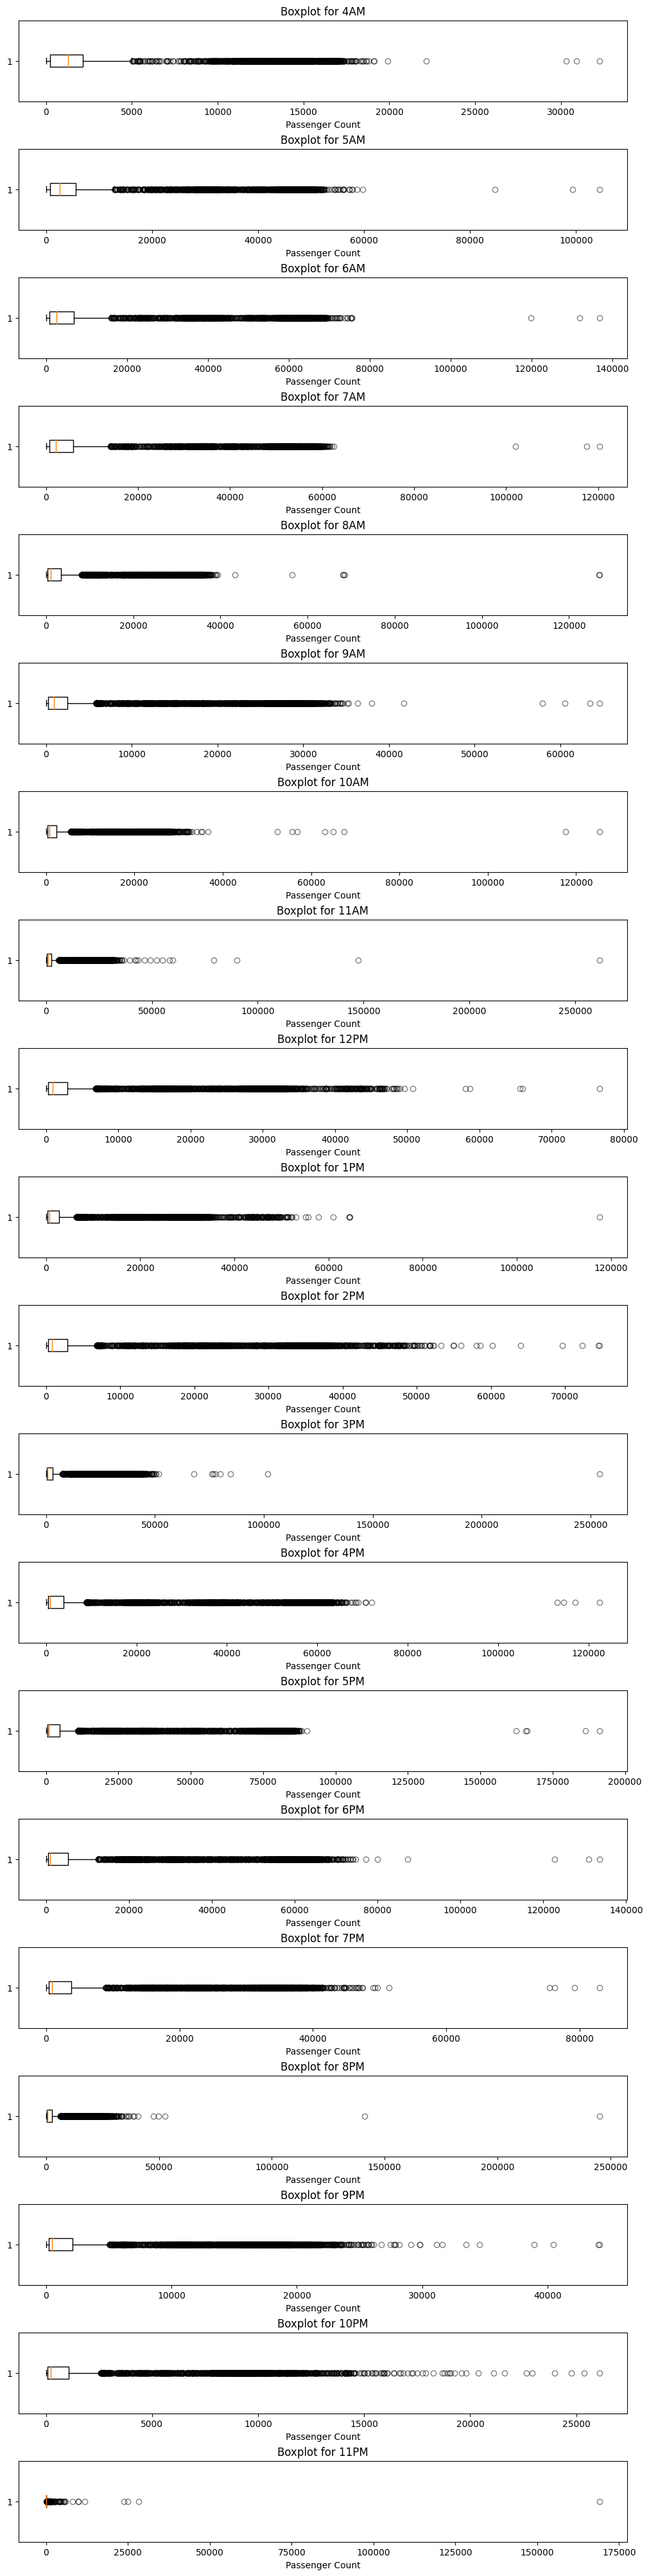

In [ ]:
def plot_outliers_boxplots(df, start_col, end_col):
    columns = df.loc[:, start_col:end_col].columns
    num_columns = len(columns)
    fig, axs = plt.subplots(nrows=num_columns, ncols=1, figsize=(10, num_columns*2), constrained_layout=True)

    for i, col in enumerate(columns):
        axs[i].boxplot(df[col].dropna(), vert=False, flierprops=dict(marker='o', color='red', alpha=0.5))
        axs[i].set_title(f'Boxplot for {col}')
        axs[i].set_xlabel('Passenger Count')

    plt.show()

plot_outliers_boxplots(df, '4AM', '11PM')

# Detección de anomalías

In [ ]:
#Solo columnas de horas
data = df.loc[:, '4AM':'11PM']

# modelo de IsolationForest para deteccion de anomalias
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(data)

df['anomaly'] = model.predict(data)

anomalies = df[df['anomaly'] == -1]
print(f'Total anomalies detected: {len(anomalies)}')

Total anomalies detected: 1020


In [ ]:
non_anomalies = df[df['anomaly'] != -1]

,Dia,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,12PM,...,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros,anomaly
count,19375,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,...,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.0
mean,2021-09-01 17:55:40.242580736,1663.054555,4275.606348,5192.924026,4495.758503,2537.331045,2165.161445,1988.664774,2096.832619,2366.066581,...,3652.701781,4654.572129,3968.304568,2632.247226,1882.794735,1455.261935,740.365677,56.912413,48605.204490,1.0
min,2019-01-01 00:00:00,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
25%,2020-06-04 00:00:00,213.000000,695.000000,812.000000,667.000000,267.000000,264.000000,256.000000,275.000000,311.000000,...,425.000000,445.000000,457.000000,371.000000,296.000000,189.000000,51.000000,11.000000,5845.500000,1.0
50%,2021-10-03 00:00:00,1161.000000,2471.000000,2409.000000,2065.000000,988.000000,840.000000,751.000000,807.000000,879.000000,...,873.000000,947.000000,937.000000,795.000000,593.000000,424.000000,201.000000,73.000000,16325.000000,1.0
75%,2022-12-02 00:00:00,2142.000000,5599.000000,6911.000000,5963.000000,2721.500000,2097.500000,2049.500000,2136.500000,2403.000000,...,3142.500000,3391.000000,4588.500000,3446.000000,2522.000000,1992.500000,1068.000000,73.000000,44207.500000,1.0
max,2024-01-31 00:00:00,19127.000000,53382.000000,68583.000000,61324.000000,38666.000000,32112.000000,28409.000000,54867.000000,33157.000000,...,68331.000000,87134.000000,68258.000000,40505.000000,35584.000000,22082.000000,13699.000000,25042.000000,749377.000000,1.0
std,NaN,2617.516438,7678.165727,10085.874716,8540.461115,5387.458152,4714.729051,4232.586078,4444.830139,5016.406490,...,9670.337012,13180.890525,9752.857501,5712.790002,3805.373510,3015.153831,1646.518673,275.816921,116255.592263,0.0


In [ ]:
# Relacion entre festivos y dia de semana en anomalias
holiday_anomalies = anomalies[anomalies['Festivo'] == True]
weekend_anomalies = anomalies[anomalies['Tipo de dia'] == 'Weekend']

print(f'Total anomalies: {len(anomalies)}')
print(f'Holiday anomalies: {len(holiday_anomalies)} ({len(holiday_anomalies) / len(anomalies) * 100:.2f}%)')
print(f'Weekend anomalies: {len(weekend_anomalies)} ({len(weekend_anomalies) / len(anomalies) * 100:.2f}%)')

Total anomalies: 1020
Holiday anomalies: 33 (3.24%)
Weekend anomalies: 0 (0.00%)


# Imputación de anomalías y outliers

In [ ]:

hour_columns = df.loc[:, '4AM':'11PM'].columns
non_anomalies = df[df['anomaly'] == 0].copy()
anomalies = df[df['anomaly'] == 1].copy()

imputer = KNNImputer(n_neighbors=5)

df[hour_columns] = imputer.fit_transform(df[hour_columns])

df.drop(columns=['anomaly'], inplace=True)

df.head()


KeyError: 'anomaly'

In [ ]:
# Imputacion de anomalias usando KNNimputer
imputer = KNNImputer(n_neighbors=5)
imputed_data = df[hour_columns].copy()
imputed_data.loc[df['anomaly'] == 1, hour_columns] = imputer.fit_transform(df[hour_columns].loc[df['anomaly'] == 1])

# Reemplazar el dataframe original por los imputados
df[hour_columns] = imputed_data

# Borramos la columna de anomalia
df.drop(columns=['anomaly'], inplace=True)

print(df.head())

#Manejo de filas duplicadas

In [ ]:
duplicated_rows = df[df.duplicated()]

print(duplicated_rows)

No hay filas duplicadas en el dataframe

#ANOVA (Analysis of variances) y ANOM (Analysis of means)

In [ ]:
from scipy.stats import f_oneway
# Filter out the partial year 2024
df = df[df['Year'] != 2024]

# Aggregate data to get average daily flow per year per line
annual_data = df.groupby(['Year', 'Linea'])['Total_pasajeros'].mean().reset_index()

In [ ]:
# Perform ANOVA for each line separately
unique_lines = annual_data['Linea'].unique()

anova_results = {}
for line in unique_lines:
    data_by_line = annual_data[annual_data['Linea'] == line]
    # Collect data for each year
    data_2019 = data_by_line[data_by_line['Year'] == 2019]['Total_pasajeros']
    data_2020 = data_by_line[data_by_line['Year'] == 2020]['Total_pasajeros']
    data_2021 = data_by_line[data_by_line['Year'] == 2021]['Total_pasajeros']
    data_2022 = data_by_line[data_by_line['Year'] == 2022]['Total_pasajeros']
    data_2023 = data_by_line[data_by_line['Year'] == 2023]['Total_pasajeros']

    # Perform ANOVA
    f_val, p_val = f_oneway(data_2019, data_2020, data_2021, data_2022, data_2023)
    anova_results[line] = (f_val, p_val)

# Output the results
for line, results in anova_results.items():
    print(f"Line {line}: F-value = {results[0]}, P-value = {results[1]}")


In [ ]:
model = ols('Total_pasajeros ~ C(Year)', data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

anova_df = pd.DataFrame(anova_results)

formatted_anova = anova_df.style.format({
    'sum_sq': "{:,.2f}",
    'df': "{:.0f}",
    'F': "{:.2f}",
    'PR(>F)': "{:.4f}"
}).set_caption("ANOVA Table").set_table_styles([{
    'selector': 'caption',
    'props': [('color', 'red'), ('font-size', '16px')]
}])

formatted_anova

,sum_sq,df,F,PR(>F)
C(Year),"5,451,560,126,140.23",5,44.99,0.0000
Residual,"494,092,353,991,412.38",20389,nan,nan


In [ ]:
def interpret_anova_results(anova_table):
    p_value = anova_table.loc['C(Year)', 'PR(>F)']
    alpha = 0.05  #Nivel de significancia

    print("\nANOVA Results Interpretation:")
    if p_value < alpha:
        print(f"The p-value ({p_value:.4f}) is less than the significance level ({alpha}), suggesting that there is a statistically significant difference in 'Total_pasajeros' across different 'Year'.")
        print("We reject the null hypothesis that there is no year-to-year variation in total passengers.")
    else:
        print(f"The p-value ({p_value:.4f}) is greater than the significance level ({alpha}), suggesting that there is no statistically significant difference in 'Total_pasajeros' across different 'Year'.")
        print("We fail to reject the null hypothesis that there is no year-to-year variation in total passengers.")

interpret_anova_results(anova_results)



ANOVA Results Interpretation:
The p-value (0.0000) is less than the significance level (0.05), suggesting that there is a statistically significant difference in 'Total_pasajeros' across different 'Year'.
We reject the null hypothesis that there is no year-to-year variation in total passengers.


In [ ]:

# Normality test using Shapiro-Wilk Test
_, pval_normality = shapiro(model.resid)
print("Normality test p-value =", pval_normality)

Normality test p-value = 0.0


In [ ]:
# Homoscedasticity test using Levene's Test
_, pval_homoscedasticity = levene(df['Total_pasajeros'][df['Year'] == 2019],
                                  df['Total_pasajeros'][df['Year'] == 2020],
                                  df['Total_pasajeros'][df['Year'] == 2021],
                                  df['Total_pasajeros'][df['Year'] == 2022],
                                  df['Total_pasajeros'][df['Year'] == 2023],
                                  df['Total_pasajeros'][df['Year'] == 2024])
print("Homoscedasticity test p-value =", pval_homoscedasticity)


Homoscedasticity test p-value = 8.410787333370019e-39


In [ ]:
import plotly.express as px

# Verificar si hay valores nulos
print(df[['Linea', 'Dia', 'Total_pasajeros']].info())
print(df[['Linea', 'Dia', 'Total_pasajeros']].isnull().sum())

# Iterar sobre cada grupo y generar el gráfico
for group_name, group_data in df.groupby('Linea'):
    if group_data.empty:
        print(f'El grupo {group_name} está vacío.')
        continue
    try:
        fig = px.line(group_data, x='Dia', y='Total_pasajeros', hover_data=['Dia_semana'],
                      title=f'Grupo: {group_name}')
        fig.show()
    except Exception as e:
        print(f'Error al generar el gráfico para el grupo {group_name}: {e}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20395 entries, 0 to 20394
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Linea            20395 non-null  category      
 1   Dia              20395 non-null  datetime64[ns]
 2   Total_pasajeros  20395 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 339.1 KB
None
Linea              0
Dia                0
Total_pasajeros    0
dtype: int64


In [ ]:
# Agrupar los datos por la columna 'Linea' y crear gráficos de línea para cada grupo
for group_name, group_data in df.groupby('Linea'):
    fig = px.line(group_data, x='Dia', y='Total_pasajeros', hover_data=['Dia_semana'],
                  title=f'Grupo: {group_name}')
    fig.show()

falta arreglar eje y

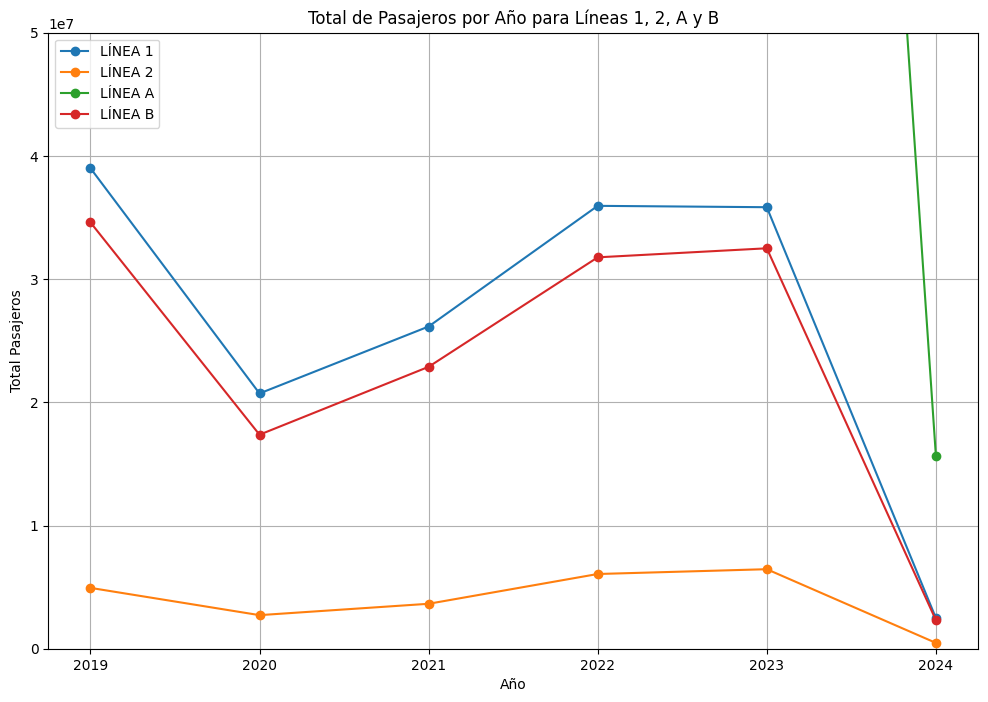

In [ ]:
# Filtrar solo las líneas 1, 2, A, y B
filtered_values = ['LÍNEA 1', 'LÍNEA 2', 'LÍNEA A', 'LÍNEA B']
df_filtered = df[df['Linea'].isin(filtered_values)]

# Agrupar los datos por 'Linea' y 'Year' y sumar 'Total Pasajeros'
df_grouped = df_filtered.groupby(['Linea', 'Year'])['Total_pasajeros'].sum().reset_index()

# Crear el gráfico de líneas con una mejor escala en el eje Y
plt.figure(figsize=(12, 8))

for linea in filtered_values:
    df_linea = df_grouped[df_grouped['Linea'] == linea]
    plt.plot(df_linea['Year'], df_linea['Total_pasajeros'], marker='o', linestyle='-', label=linea)

plt.title('Total de Pasajeros por Año para Líneas 1, 2, A y B')
plt.xlabel('Año')
plt.ylabel('Total Pasajeros')
plt.grid(True)
plt.legend()
plt.xticks(df_grouped['Year'].unique())  # Asegura que solo se muestren años completos en el eje x

# Ajustar los límites del eje Y para una mejor visualización
plt.ylim(0, 0.5e8)  # Ajustar según sea necesario

plt.show()

#Preprocesamiento de datos



1.   Creación de lagged features
2.   Normalización de los datos
3.   División de datos de entrenamiento y datos de prueba.



In [ ]:
# Definimos numero de lags
n_lags = 7  # Creamos features por los 7 dias pasados

# Crecion de lagged features para cada columna de hora
for lag in range(1, n_lags + 1):
    for col in df.loc[:, '4AM':'11PM'].columns:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# quitamos las filas con NaN dadas por el proceso de laggeado
df = df.dropna()

print(df.head())

In [ ]:
split_date = '2022-12-31'
train_data = df[df['Dia'] <= split_date]
test_data = df[df['Dia'] > split_date]


hour_columns = df.loc[:, '4AM':'11PM'].columns
features = hour_columns
target = 'Total_pasajeros'

scaler = MinMaxScaler()
train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])

class TimeSeriesDataset(Dataset):
    def __init__(self, data, features, target):
        self.features = data[features].values
        self.target = data[target].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.target[idx], dtype=torch.float32)
        return x, y

train_dataset = TimeSeriesDataset(train_data, features, target)
test_dataset = TimeSeriesDataset(test_data, features, target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,8PM,9PM,10PM,11PM,Total_pasajeros,Festivo,Dia_semana,Tipo de dia,Mes,Year
0,2019-01-01,LÍNEA 1,12.0,826.0,1134.0,987.0,884.0,975.0,1259.0,1348.0,...,2024.0,1257.0,271.0,5.0,28850,True,1,Entre semana,1,2019
1,2019-01-02,LÍNEA 1,1716.0,4498.0,6629.0,6284.0,4145.0,3784.0,3746.0,3854.0,...,2975.0,2709.0,1890.0,135.0,83484,False,2,Entre semana,1,2019
2,2019-01-03,LÍNEA 1,1860.0,4869.0,7587.0,7088.0,4483.0,4486.0,4126.0,4136.0,...,3244.0,2905.0,1739.0,124.0,90472,False,3,Entre semana,1,2019
3,2019-01-04,LÍNEA 1,1845.0,4989.0,7723.0,7281.0,4857.0,4583.0,4269.0,4217.0,...,3466.0,3075.0,1900.0,176.0,93067,False,4,Entre semana,1,2019
4,2019-01-05,LÍNEA 1,1550.0,3852.0,4898.0,5221.0,4016.0,3815.0,3704.0,4048.0,...,2973.0,2866.0,1983.0,167.0,75451,False,5,Fin de semana,1,2019


# Creacion de LSTM

In [ ]:
import torch.nn as nn
import torch.optim as optim

class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.supports_masking = True
        self.bias = bias
        self.attention = nn.Parameter(torch.FloatTensor(feature_dim, 1))
        if bias:
            self.b = nn.Parameter(torch.FloatTensor(step_dim))
        nn.init.xavier_normal_(self.attention)
        if bias:
            nn.init.constant_(self.b, 0.0)

    def forward(self, x):
        eij = torch.matmul(x.contiguous(), self.attention).squeeze(-1)
        if self.bias:
            eij = eij + self.b
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        a = a / torch.sum(a, 1, keepdim=True) + 1e-10
        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, attention_dim, output_dim, n_layers):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.attention = Attention(hidden_dim, attention_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h_lstm, _ = self.lstm(x)
        h_lstm_atten = self.attention(h_lstm)
        out = self.fc(h_lstm_atten)
        return out

#Paremetros del modelo
input_dim = len(features)
hidden_dim = 50
attention_dim = input_dim
output_dim = 1
n_layers = 1

model = LSTMWithAttention(input_dim, hidden_dim, attention_dim, output_dim, n_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# Training

In [ ]:
def adjust_weights(data):
    weights = np.ones(len(data))
    weights[data['Dia'].dt.year == 2020] = 0.5
    weights[data['Dia'].dt.year == 2019] = 1.5
    weights[data['Dia'].dt.year == 2023] = 1.5
    return torch.tensor(weights, dtype=torch.float32)

train_weights = adjust_weights(train_data)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.unsqueeze(1).to(device)  # Reshape para LSTM input
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass y optimizacion
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

# Evaluacion del modelo
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.unsqueeze(1).to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')
